In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [19]:
df = pd.read_csv("./mlb_elo.csv")

In [20]:
df.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
0,2021-10-03,2021,0,NaN,ATL,NYM,1520.302033,1511.617803,0.546898,0.453102,...,NaN,NaN,NaN,NaN,0.514740,0.485260,NaN,NaN,NaN,NaN
1,2021-10-03,2021,0,NaN,STL,CHC,1519.691110,1525.797177,0.525729,0.474271,...,NaN,NaN,NaN,NaN,0.527320,0.472680,NaN,NaN,NaN,NaN
2,2021-10-03,2021,0,NaN,SEA,ANA,1479.484611,1478.455457,0.535958,0.464042,...,NaN,NaN,NaN,NaN,0.499610,0.500390,NaN,NaN,NaN,NaN
3,2021-10-03,2021,0,NaN,LAD,MIL,1579.554567,1502.598988,0.641331,0.358669,...,NaN,NaN,NaN,NaN,0.646189,0.353811,NaN,NaN,NaN,NaN
4,2021-10-03,2021,0,NaN,KCR,MIN,1473.202406,1498.953739,0.497480,0.502520,...,NaN,NaN,NaN,NaN,0.472238,0.527762,NaN,NaN,NaN,NaN


In [21]:
df.columns

Index(['date', 'season', 'neutral', 'playoff', 'team1', 'team2', 'elo1_pre',
       'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post', 'elo2_post',
       'rating1_pre', 'rating2_pre', 'pitcher1', 'pitcher2', 'pitcher1_rgs',
       'pitcher2_rgs', 'pitcher1_adj', 'pitcher2_adj', 'rating_prob1',
       'rating_prob2', 'rating1_post', 'rating2_post', 'score1', 'score2'],
      dtype='object')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223388 entries, 0 to 223387
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   date          223388 non-null  object 
 1   season        223388 non-null  int64  
 2   neutral       223388 non-null  int64  
 3   playoff       1670 non-null    object 
 4   team1         223388 non-null  object 
 5   team2         223388 non-null  object 
 6   elo1_pre      223388 non-null  float64
 7   elo2_pre      223388 non-null  float64
 8   elo_prob1     223388 non-null  float64
 9   elo_prob2     223388 non-null  float64
 10  elo1_post     221732 non-null  float64
 11  elo2_post     221732 non-null  float64
 12  rating1_pre   223388 non-null  float64
 13  rating2_pre   223388 non-null  float64
 14  pitcher1      221829 non-null  object 
 15  pitcher2      221821 non-null  object 
 16  pitcher1_rgs  188126 non-null  float64
 17  pitcher2_rgs  188118 non-null  float64
 18  pitc

In [23]:
df.isnull().sum()

date                 0
season               0
neutral              0
playoff         221718
team1                0
team2                0
elo1_pre             0
elo2_pre             0
elo_prob1            0
elo_prob2            0
elo1_post         1656
elo2_post         1656
rating1_pre          0
rating2_pre          0
pitcher1          1559
pitcher2          1567
pitcher1_rgs     35262
pitcher2_rgs     35270
pitcher1_adj     35943
pitcher2_adj     35950
rating_prob1         0
rating_prob2         0
rating1_post      1656
rating2_post      1656
score1            1656
score2            1656
dtype: int64

In [24]:
# column 'playoff' has the most NaN values for the dataset
# so it makes sense to remove it
df = df.drop(columns=['playoff'])

In [25]:
df.isnull().sum()

date                0
season              0
neutral             0
team1               0
team2               0
elo1_pre            0
elo2_pre            0
elo_prob1           0
elo_prob2           0
elo1_post        1656
elo2_post        1656
rating1_pre         0
rating2_pre         0
pitcher1         1559
pitcher2         1567
pitcher1_rgs    35262
pitcher2_rgs    35270
pitcher1_adj    35943
pitcher2_adj    35950
rating_prob1        0
rating_prob2        0
rating1_post     1656
rating2_post     1656
score1           1656
score2           1656
dtype: int64

In [26]:
# dropping rows with NaN values
df = df.dropna()

In [27]:
df.shape

(187308, 25)

In [28]:
df['date'] = pd.to_datetime(df['date'])

In [29]:
# feature engineering - creating a win/loss outcome for every team
df['match_outcome'] = df.apply(lambda row: 1 if row['score1'] > row['score2'] else 0, axis=1)

In [30]:
df.head()

,date,season,neutral,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,...,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2,match_outcome
1656,2021-05-29,2021,0,SEA,TEX,1478.232257,1468.429332,0.548493,0.451507,1479.484611,...,51.535568,10.048869,8.334523,0.549112,0.450888,1469.208247,1458.810231,3.0,2.0,1
1657,2021-05-29,2021,0,ARI,STL,1470.837067,1517.687775,0.467163,0.532837,1468.833732,...,52.576120,-13.636972,5.708600,0.448091,0.551909,1467.262980,1510.965758,4.0,7.0,0
1658,2021-05-29,2021,0,WSN,MIL,1506.964453,1499.670281,0.544915,0.455085,1504.035746,...,49.046639,-24.516408,-22.061039,0.528863,0.471137,1507.780893,1513.480235,2.0,6.0,0
1659,2021-05-29,2021,0,NYM,ATL,1506.915517,1525.004318,0.508506,0.491494,1511.617803,...,56.131278,-1.458600,15.311439,0.519598,0.480402,1537.047428,1523.249507,13.0,2.0,1
1660,2021-05-29,2021,0,LAD,SFG,1583.449141,1529.795941,0.609928,0.390072,1579.554567,...,48.572938,-7.925001,-12.522449,0.665280,0.334720,1595.498957,1511.335961,6.0,11.0,0


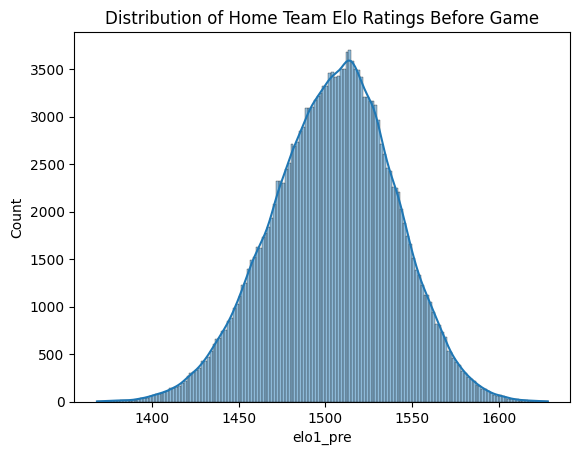

In [32]:
# Distribution of ELO ratings
sns.histplot(df['elo1_pre'], kde=True)
plt.title('Distribution of Home Team Elo Ratings Before Game')
plt.show()

<ipython-input-33-b5b0fefb89ba>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(['Loss', 'Win'], ha='right')


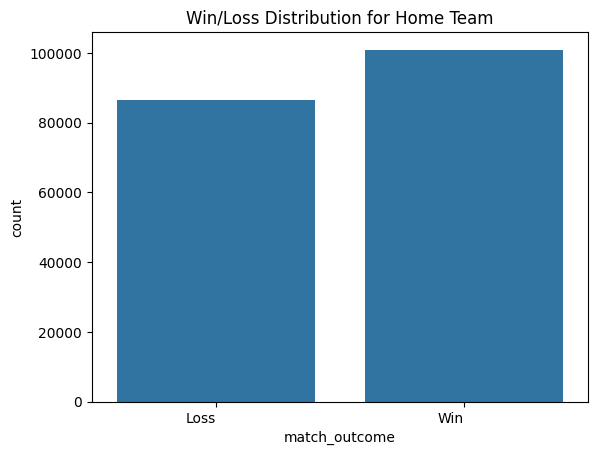

In [33]:
# Win/Loss distribution Visualization
plot = sns.countplot(x='match_outcome', data=df)
plot.set_xticklabels(['Loss', 'Win'], ha='right')
plt.title('Win/Loss Distribution for Home Team')
plt.show()

In [34]:
# Filter data for the year 2021
df_2021 = df[df['date'].dt.year == 2021]

This is another way to extract x% of data from the dataset, on a random basis.
We are sampling 10% of the data randomly from the entire population (which is the entire dataset in this case).

```
percentage_to_keep = 0.1
rows_to_keep = int(len(df) * percentage_to_keep)
reduced_data = df.sample(n=rows_to_keep, random_state=42)
```



In [35]:
df_2021.shape

(771, 26)

In [36]:
X = df_2021[['elo1_pre', 'elo2_pre', 'rating1_pre', 'rating2_pre']]
y = df_2021['match_outcome']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
scaler = StandardScaler()

In [39]:
# scaling the data using the StandardScaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
# performing Random Forest Classification
rf = RandomForestClassifier()

In [41]:
# parameter dictionary for grid search
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10]
}

In [42]:
# creating the GridSearchCV (Grid Search Cross Validation) object
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', verbose=1)

In [71]:
grid_search_rf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20], 'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [72]:
# obtaining the best estimator
best_rf = grid_search_rf.best_estimator_
print(best_rf)

# predicting the values from the X_test_scaled
y_pred_rf = best_rf.predict(X_test_scaled)

# obtaining the accuracy score
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Test Accuracy: {test_accuracy_rf:.4f}')
print(classification_report(y_test, y_pred_rf))

RandomForestClassifier(max_depth=20, n_estimators=200)
Random Forest Test Accuracy: 0.6516
              precision    recall  f1-score   support

           0       0.59      0.66      0.62        68
           1       0.71      0.64      0.67        87

    accuracy                           0.65       155
   macro avg       0.65      0.65      0.65       155
weighted avg       0.66      0.65      0.65       155

